Tên: Nguyễn Thọ Anh Khoa

Facebook: Khoa Nguyễn KT

Lớp: AI Insight 

# Multilayer Perceptron – Exercise 1

## 1) Đọc hiểu code file “Softmax-Researcher-L2.ipynb” về weight decay loss


Ở phần code này thực hiện sofmax regression trên tập data iris sử dụng tensorflow và khởi tạo weight lớn, ta có thể thấy được loss được vẽ ra gần như là 1 đường thẳng, có nghĩa model dường như không học được gì từ tập data. Để khắc phục được vấn đề này phương thức **weight decay** được áp dụng.

In [ ]:
# large init values for theta

import numpy as np
import tensorflow as tf
tf.keras.backend.set_floatx('float64')

### Data preparation
data = np.genfromtxt('exercise 8/iris/iris_full.csv', delimiter=',', skip_header=1)
X = data[:,0:4]
y = data[:,4:]

# add 1
X = np.hstack((np.ones((150, 1)), X))

# predict    
def predict(x, theta):
    return tf.math.softmax(tf.matmul(x, theta))

    
### weights
theta = tf.Variable(tf.random.normal((5, 3), dtype=tf.float64)*5)

### training
learning_rate = 0.1
num_epochs = 2000

### loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy()

losses = [] # for debug
for epoch in range(num_epochs):
    with tf.GradientTape() as t:
        # output
        output = predict(X, theta)
        
        # loss
        loss_v = loss(y, output)
        losses.append(loss_v.numpy())
        
        # gradient
        dtheta = t.gradient(loss_v, theta)
        
        # update
        theta.assign_sub(learning_rate * dtheta) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Text(0, 0.5, 'Loss')

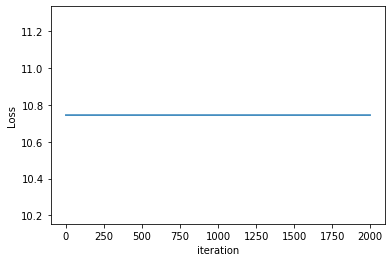

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('Loss')

Kỹ thuật này được gọi là regularization và nó có 2 loại (L1) Lasso Regression (L2) Ridge Regression. Phần code này thực hiện L2:
$$ Loss_{\pmb{\theta}} = 1/2 * ||\pmb{y - \hat{y}}||^2_2 + \lambda*||\pmb{W}||^2_2 $$

trong L2 là $\lambda*||\pmb{W}||^2_2$ với lambda là regularization strength tức là lambda càng lớn thì recgularzation càng mạnh và ngược lại.

Công thức này có ý nghĩa là cứ mỗi wieght w trong network thì $1/2\lambda \pmb{w}$ được add vào. Để phạt mạnh vào các vector w đỉnh và ưu tiên các w phân tán (có nghĩa là sẽ không để wieght bị lệch mà giúp model phân tán đều weight để học được tổng quát hơn, khi 1 vector weight càng lớn thì loss càng cao để phạt vào). Điều này sẽ giúp cho network sử dụng mỗi thử 1 chút ở tất cả input để học thay vì trỉ tập trung vào 1 vài input.

Trong phần code bên dưới weight_loss đươc tính theo công thức trên và lấy trung bình cộng với lambda = 0.1

In [ ]:
# Loss for large weights

import numpy as np
import tensorflow as tf
tf.keras.backend.set_floatx('float64')

### Data preparation
data = np.genfromtxt('exercise 8/iris/iris_full.csv', delimiter=',', skip_header=1)
X = data[:,0:4]
y = data[:,4:]

# add 1
X = np.hstack((np.ones((150, 1)), X))

# predict    
def predict(x, theta):
    return tf.math.softmax(tf.matmul(x, theta))

    
### weights
theta = tf.Variable(tf.random.normal((5, 3), dtype=tf.float64)*5)

### training
learning_rate = 0.1
num_epochs = 2000

### loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy()

losses = [] # for debug
for epoch in range(num_epochs):
    with tf.GradientTape() as t:
        # output
        output = predict(X, theta)
        
        # loss
        weight_loss = tf.math.reduce_sum(theta**2) / (theta.shape[0]*theta.shape[1])
        loss_v = loss(y, output) + 0.1*weight_loss
        losses.append(loss_v.numpy())
        
        # gradient
        dtheta = t.gradient(loss_v, theta)
        
        # update
        theta.assign_sub(learning_rate * dtheta) 

Text(0, 0.5, 'Loss')

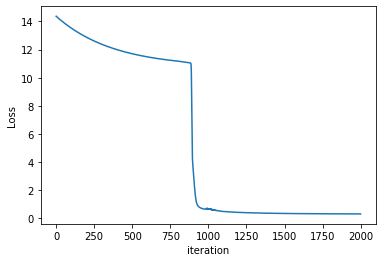

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('Loss')

## 2) Đọc hiểu code file “1.MNIST-Preparation.ipynb” về cách xử lý dữ liệu hình MNIST.

Đây là phần code down load data từ trang web bằng python
- Thư viện **urllib** dùng package **request** để gửi request download data tới server và download data bằng lệnh **request.urlretrieve(link_file_download, folder_contains_file) **


In [ ]:
import numpy as np
from urllib import request
import gzip
import pickle

filenames = ["train-images-idx3-ubyte.gz", "t10k-images-idx3-ubyte.gz", 
            "train-labels-idx1-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]


folder = 'data_mnist/'
def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filenames:
        print("Downloading " + name + "...")
        request.urlretrieve(base_url + name, folder + name)
    print("Download complete.")

download_mnist()

Download complete.


- File down về có entension là .gz là 1 chuẩn nén GNU zip (gzip), do đó thư viện **gzip** được import để  load data và có thể load file mà không cần giải nén.
- Khi open file bằng gzip với type là byte, sau đó **np.frombuffer** được dùng để load data
- Tập ảnh thì cần set X cần set offset là 16 và label là 8. Các 16, 8 byte đầu là magic byte không cần quan tâm.
- Ảnh được reshape để  có shape là (sample, features) ở đây features thì mỗi element là 1 pixel (ảnh 28x28)
- Sau đó data sẽ được save theo format của npy, cách này giúp load data nhanh hơn cho các lần load data sau vì data đã được xử lý trước đó 

In [ ]:
import numpy as np
import gzip

# load training images
with gzip.open('data_mnist/train-images-idx3-ubyte.gz', 'rb') as f:
    X_train = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)

# load testing images
with gzip.open('data_mnist/t10k-images-idx3-ubyte.gz', 'rb') as f:
    X_test = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)

# load training labels
with gzip.open('data_mnist/train-labels-idx1-ubyte.gz', 'rb') as f:
    y_train = np.frombuffer(f.read(), np.uint8, offset=8)
    
# load testing labels
with gzip.open('data_mnist/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    y_test = np.frombuffer(f.read(), np.uint8, offset=8)
    

# check data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

np.save('data_mnist/X_train.npy', X_train)
np.save('data_mnist/y_train.npy', y_train)
np.save('data_mnist/X_test.npy', X_test)
np.save('data_mnist/y_test.npy', y_test)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


Đây là bước để kiểm tra các data bằng cách load file đã lưu và dung thư viện xử lý ảnh **PIL**, conver array sang PIL object và save 10 ảnh để kiểm tra 

In [ ]:
from PIL import Image
import numpy as np  

X_train = np.load('data_mnist/X_train.npy', allow_pickle=True)
print(X_train.shape)

for i in range(10):
    im = Image.fromarray(X_train[i].reshape(28,28))
    im.save("data_mnist/images/image_" + str(i) +".jpg")

(60000, 784)


Ở đoạn code trên phải save ra image file mới check được, thì đoạn code bên dưới dùng thư viện matplotlib để show lên trực tiếp không cần save ra file ảnh 

- Vì tập train có 60000 ảnh nên chỉ show random vài ảnh ở đây sẽ show 1 grid ảnh với 8 hàng 8 cột 
- **plt.figure(figsize=(9,9))** để set size của ảnh 
- **fig.add_subplot(rows, columns, i)** vẽ từ trái sang phải cho đến hình thứ row*columns
- Ý tưởng chính của code là pick pick random 64 index trong 60000, sau đó cho vòng lập chạy từ 1 đến 65 (64 samples) rồi vẽ từng ảnh lên grid có kích thước 8*8 

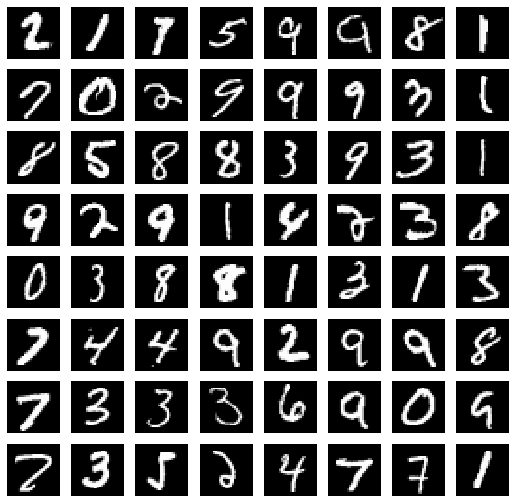

In [ ]:
# dùng vẽ đồ thị, hình ảnh
import matplotlib.pyplot as plt 

# Tạo dang sách 9 phần tử ngẫu nhiên từ m_train có 60.000 phần tử
indices = list(np.random.randint(60000, size=64))

fig = plt.figure(figsize=(9,9))
columns = 8
rows = 8
for i in range(1, columns*rows +1):
    img = X_train[indices[i-1]].reshape(28,28)
    fig.add_subplot(rows, columns, i)
    
    plt.axis('off')
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)

## 3) Đọc hiểu code các file sau cho việc áp dụng Softmax regression và perceptron cho data MNIST

## a) 2.Softmax-Researcher-MNIST.ipynb

## b) 3.Softmax-MLP-MNIST.ipynb

### a) 2.Softmax-Researcher-MNIST.ipynb

Ví dụ này cho thấy sự không ổn định trong quá trình training khi không normalize data
phần đầu tiên data đã được normalize, vì là ảnh nên sẽ có range từ 0-255, do đó đoạn code này chia toàn bộ data cho 255 để scale về range 0-1. Việc này sẽ đem lại nhiều lợi ích:

- Giúp cho việc tính toán nhanh hơn thay vì range 0-255
- Các pixel có cùng scale range sẽ học được tổng quát hơn thay vì model sẽ tập trung vào các pixel lớn như 255 làm cho model không ổn định và học chậm hơn.


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
tf.keras.backend.set_floatx('float64')

# Data Preparation
X_train = np.load('data_mnist/X_train.npy', allow_pickle=True)
y_train = np.load('data_mnist/y_train.npy', allow_pickle=True)
X_test = np.load('data_mnist/X_test.npy', allow_pickle=True)
y_test = np.load('data_mnist/y_test.npy', allow_pickle=True)

X_train = X_train/255
X_test  = X_test/255

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print(y_train[:5])

# predict    
def predict(x, W, b):
    return tf.math.softmax(tf.matmul(x, W) + b)

    
### weights
W = tf.Variable(tf.random.normal((784, 10), mean=0, stddev=0.1, dtype=tf.float64))
b = tf.Variable(tf.zeros((10,), dtype=tf.float64))

### training
learning_rate = 0.1
num_epochs = 300

### loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy()

losses = [] # for debug
for epoch in range(num_epochs):
    with tf.GradientTape() as t:
        # output
        output = predict(X_train, W, b)
        
        # loss
        loss_v = loss(y_train, output)
        losses.append(loss_v.numpy())
        
        # gradient
        dW, db = t.gradient(loss_v, [W, b])
        
        # update
        W.assign_sub(learning_rate * dW) 
        b.assign_sub(learning_rate * db)

(60000, 784)
(60000,)
(10000, 784)
(10000,)
[5 0 4 1 9]


Text(0, 0.5, 'Loss')

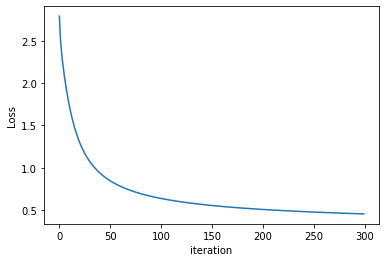

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('Loss')

(60000, 784)
(60000,)
(10000, 784)
(10000,)


Text(0, 0.5, 'Loss')

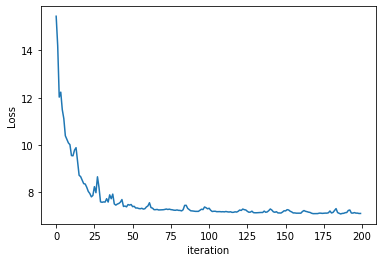

In [ ]:
# without normalization

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
tf.keras.backend.set_floatx('float64')

# Data Preparation
X_train = np.load('data_mnist/X_train.npy', allow_pickle=True)
y_train = np.load('data_mnist/y_train.npy', allow_pickle=True)
X_test = np.load('data_mnist/X_test.npy', allow_pickle=True)
y_test = np.load('data_mnist/y_test.npy', allow_pickle=True)

X_train = X_train.astype(np.float64)
X_test  = X_test.astype(np.float64)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# predict    
def predict(x, W, b):
    return tf.math.softmax(tf.matmul(x, W) + b)

    
### weights
W = tf.Variable(tf.random.normal((784, 10), mean=0, stddev=0.1, dtype=tf.float64))
b = tf.Variable(tf.zeros((10,), dtype=tf.float64))

### training
learning_rate = 0.1
num_epochs = 200

### loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy()

losses = [] # for debug
for epoch in range(num_epochs):
    with tf.GradientTape() as t:
        # output
        output = predict(X_train, W, b)
        
        # loss
        loss_v = loss(y_train, output)
        losses.append(loss_v.numpy())
        
        # gradient
        dW, db = t.gradient(loss_v, [W, b])
        
        # update
        W.assign_sub(learning_rate * dW) 
        b.assign_sub(learning_rate * db)
        

import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('Loss')

## b) 3.Softmax-MLP-MNIST.ipynb


Đây là model dùng để train tập mnis với kiến trúc là 1 layer input 784 nodes và 1 hidden output layer 10 nodes sử dụng softmax activation, khởi tạo random weight theo Normal Distribution với standart devivation = 0.01, bias = 0, hàm loss là spare categorical crossentropy. Train 50 epochs với batch size = 512

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
tf.keras.backend.set_floatx('float64')

# Data Preparation
X_train = np.load('data_mnist/X_train.npy', allow_pickle=True)
y_train = np.load('data_mnist/y_train.npy', allow_pickle=True)
X_test = np.load('data_mnist/X_test.npy', allow_pickle=True)
y_test = np.load('data_mnist/y_test.npy', allow_pickle=True)

X_train = X_train/255
X_test  = X_test/255


batch_size = 512
epochs = 50

# create model
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(784,)))
model.add(tf.keras.layers.Dense(10, activation='softmax', 
                               kernel_initializer=keras.initializers.RandomNormal(stddev=0.01),
                               bias_initializer=keras.initializers.Zeros()))

# declare optimization method and loss function
model.compile(optimizer='sgd', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# training
history = model.fit(X_train, y_train, batch_size, epochs)

# testing
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('\n\nTest accuracy:', test_acc)

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 36us/sample - loss: 1.8276 - accuracy: 0.6754
Epoch 2/50
60000/60000 [==============================] - 1s 10us/sample - loss: 1.2693 - accuracy: 0.7966
Epoch 3/50
60000/60000 [==============================] - 1s 10us/sample - loss: 1.0123 - accuracy: 0.8207
Epoch 4/50
60000/60000 [==============================] - 1s 10us/sample - loss: 0.8709 - accuracy: 0.8329
Epoch 5/50
60000/60000 [==============================] - 1s 13us/sample - loss: 0.7816 - accuracy: 0.8421
Epoch 6/50
60000/60000 [==============================] - 1s 13us/sample - loss: 0.7197 - accuracy: 0.8485
Epoch 7/50
60000/60000 [==============================] - 1s 11us/sample - loss: 0.6740 - accuracy: 0.8535
Epoch 8/50
60000/60000 [==============================] - 1s 11us/sample - loss: 0.6386 - accuracy: 0.8577
Epoch 9/50
60000/60000 [==============================] - 1s 10us/sample - loss: 0.6104 - accuracy: 0.8612
Epoch 10/50
60

Text(0, 0.5, 'Loss')

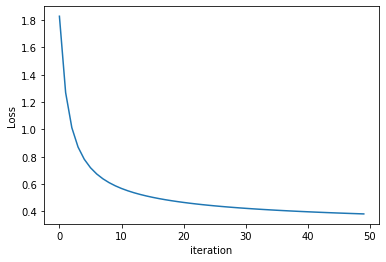

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('iteration')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

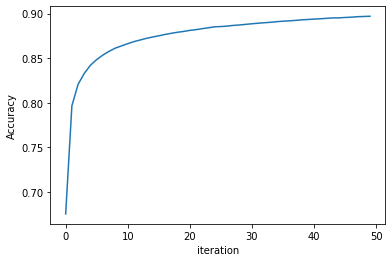

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.xlabel('iteration')
plt.ylabel('Accuracy')

Model này có kiến trúc Input 784 nodes, 1 hidden layer 128 node, ouput layer 10 node, Mặc dù model này sâu hơn (nhiều parameter) hơn model trên, theo lý thuyết thì sẽ có khả năng học được nhiều hơn và tốt hơn nhưng kết quả trên tập test (data không được train) thì lại tệ hơn, thì có thể do model đã bị overfitting trên tập train

In [ ]:
# MLP - sigmoid

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
tf.keras.backend.set_floatx('float64')

# Data Preparation
X_train = np.load('data_mnist/X_train.npy', allow_pickle=True)
y_train = np.load('data_mnist/y_train.npy', allow_pickle=True)
X_test = np.load('data_mnist/X_test.npy', allow_pickle=True)
y_test = np.load('data_mnist/y_test.npy', allow_pickle=True)

X_train = X_train/255
X_test  = X_test/255


batch_size = 512
epochs = 50

# create model
model = tf.keras.Sequential()

model.add(tf.keras.Input(shape=(784,)))

model.add(tf.keras.layers.Dense(128, activation='sigmoid', 
                               kernel_initializer=keras.initializers.RandomNormal(stddev=0.01),
                               bias_initializer=keras.initializers.Zeros()))

model.add(tf.keras.layers.Dense(10, activation='softmax', 
                               kernel_initializer=keras.initializers.RandomNormal(stddev=0.01),
                               bias_initializer=keras.initializers.Zeros()))

# declare optimization method and loss function
model.compile(optimizer='sgd', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# training
history = model.fit(X_train, y_train, batch_size, epochs)

# testing
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('\n\nTest accuracy:', test_acc)

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 32us/sample - loss: 2.3009 - accuracy: 0.1112
Epoch 2/50
60000/60000 [==============================] - 1s 24us/sample - loss: 2.2986 - accuracy: 0.1124
Epoch 3/50
60000/60000 [==============================] - 1s 25us/sample - loss: 2.2965 - accuracy: 0.1124
Epoch 4/50
60000/60000 [==============================] - 2s 27us/sample - loss: 2.2941 - accuracy: 0.1124
Epoch 5/50
60000/60000 [==============================] - 1s 24us/sample - loss: 2.2911 - accuracy: 0.1124
Epoch 6/50
60000/60000 [==============================] - 1s 24us/sample - loss: 2.2874 - accuracy: 0.1125
Epoch 7/50
60000/60000 [==============================] - 1s 24us/sample - loss: 2.2827 - accuracy: 0.1149
Epoch 8/50
60000/60000 [==============================] - 1s 24us/sample - loss: 2.2766 - accuracy: 0.1405
Epoch 9/50
60000/60000 [==============================] - 1s 24us/sample - loss: 2.2688 - accuracy: 0.1642
Epoch 10/50
60

## 4) (Optional) Cài đặt Softmax regression và perceptron cho data Fashion-MNIST
https://github.com/zalandoresearch/fashion-mnist

In [2]:
import numpy as np
import gzip
from urllib import request
import pathlib 

data_name = ['train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']
parent_dir = 'Fashion_MNIST/'
url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'

for name in data_name:
    print("Downloading " + name + "...")
    request.urlretrieve(url + name, parent_dir+name)
print("Download complete.")



Download complete.


In [3]:
import numpy as np
import gzip

# load training images
with gzip.open('Fashion_MNIST/train-images-idx3-ubyte.gz', 'rb') as f:
    X_train = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)

# load testing images
with gzip.open('Fashion_MNIST/t10k-images-idx3-ubyte.gz', 'rb') as f:
    X_test = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)

# load training labels
with gzip.open('Fashion_MNIST/train-labels-idx1-ubyte.gz', 'rb') as f:
    y_train = np.frombuffer(f.read(), np.uint8, offset=8)
    
# load testing labels
with gzip.open('Fashion_MNIST/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    y_test = np.frombuffer(f.read(), np.uint8, offset=8)
    

# check data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

np.save('Fashion_MNIST/X_train.npy', X_train)
np.save('Fashion_MNIST/y_train.npy', y_train)
np.save('Fashion_MNIST/X_test.npy', X_test)
np.save('Fashion_MNIST/y_test.npy', y_test)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


### Softmax regression

In [4]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
tf.keras.backend.set_floatx('float64')

# load data
X_train = np.load('Fashion_MNIST/X_train.npy', allow_pickle=True)
y_train = np.load('Fashion_MNIST/y_train.npy', allow_pickle=True)
X_test = np.load('Fashion_MNIST/X_test.npy', allow_pickle=True)
y_test = np.load('Fashion_MNIST/y_test.npy', allow_pickle=True)

# Normalize data
# X_train = X_train * 1./255
# X_test = X_test * 1./255
def normalize_data(X):
    # X = X * 1./255
    return (X - np.mean(X)) / np.std(X)
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)

# Initial weight
features = X_train.shape[1]
num_class = len(np.unique(y_train))
W = tf.Variable(tf.random.normal( (features, num_class), mean=0, stddev=0.1, dtype=tf.float64))
b = tf.Variable(tf.zeros((num_class,), dtype=tf.float64))

# training
epochs = 300
learning_rate = 0.1

# loss fnc
loss_fcn = keras.losses.SparseCategoricalCrossentropy()

def predict(X,W,b):
    return tf.math.softmax(tf.matmul(X,W) +b)

losses = []
for epoch in range(epochs):
    with tf.GradientTape(persistent=True) as tape:
        #forward
        pred = predict(X_train,W,b)
        
        #loss
        loss = loss_fcn(y_train, pred)
        losses.append(loss.numpy())
        
        #gradient
        dW, db = tape.gradient(loss, [W, b])
        
        #update
        W.assign_sub(learning_rate*dW)
        b.assign_sub(learning_rate*db)

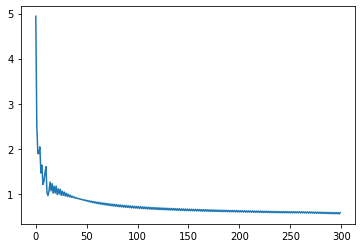

In [5]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

In [7]:
pred_test = predict(normalize_data(X_test),W,b)
pred_test_class = np.argmax(pred_test.numpy(), axis=1)
np.mean(pred_test_class == y_test)

0.7957

0.77 -> 0.8

### MLP

In [8]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
tf.keras.backend.set_floatx('float64')

# load data
X_train = np.load('Fashion_MNIST/X_train.npy', allow_pickle=True)
y_train = np.load('Fashion_MNIST/y_train.npy', allow_pickle=True)
X_test = np.load('Fashion_MNIST/X_test.npy', allow_pickle=True)
y_test = np.load('Fashion_MNIST/y_test.npy', allow_pickle=True)

# Normalize data
# X_train = X_train * 1./255
# X_test = X_test * 1./255
def normalize_data(X):
    # X = X * 1./255
    return (X - np.mean(X)) / np.std(X)
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)

# Initial weight
features = X_train.shape[1]
units_hid1 = 128
num_class = len(np.unique(y_train))

W1 = tf.Variable(tf.random.normal( (features, units_hid1), mean=0, stddev=0.1, dtype=tf.float64))
b1 = tf.Variable(tf.zeros((units_hid1,), dtype=tf.float64))

W_out = tf.Variable(tf.random.normal( (units_hid1, num_class), mean=0, stddev=0.1, dtype=tf.float64))
b_out = tf.Variable(tf.zeros((num_class,), dtype=tf.float64))

# training
epochs = 300
learning_rate = 0.1

# loss fnc
loss_fcn = keras.losses.SparseCategoricalCrossentropy()

def out_hid(X,W,b):
    return tf.nn.relu(tf.matmul(X,W) +b)
def predict(X,W,b):
    return tf.math.softmax(tf.matmul(X,W) +b)

losses = []
for epoch in range(epochs):
    with tf.GradientTape(persistent=True) as tape:
        #forward
        out_hid1 = out_hid(X_train,W1,b1)
        pred = predict(out_hid1,W_out,b_out)
        
        #loss
        loss = loss_fcn(y_train, pred)
        losses.append(loss.numpy())
        
        #gradient
        dW1, db1 = tape.gradient(loss, [W1, b1])
        dW_out, db_out = tape.gradient(loss, [W_out, b_out])
        
        #update
        W1.assign_sub(learning_rate*dW1)
        b1.assign_sub(learning_rate*db1)
        W_out.assign_sub(learning_rate*dW_out)
        b_out.assign_sub(learning_rate*db_out)

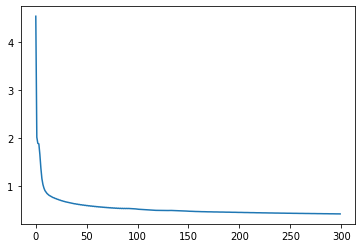

In [9]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

In [10]:
out_hid1 = out_hid(normalize_data(X_test),W1,b1)
pred_test = predict(out_hid1,W_out,b_out)
pred_test_class = np.argmax(pred_test.numpy(), axis=1)
np.mean(pred_test_class == y_test)

0.8343

## References

1/

https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd

https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

https://cs231n.github.io/neural-networks-2/#init

https://machinelearningcoban.com/2017/03/04/overfitting/#-%5C%5Cl%5C%5C-regularization

2/

https://mattpetersen.github.io/load-mnist-with-numpy

batch?, fnc arbitrary # layers?